In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
# Load train data
data_folder_path = Path('data/')
train_data = pd.read_csv(data_folder_path / 'data_train_all.csv')
train_data_columns = pd.read_csv(data_folder_path / 'data_train_all_columns.csv')

test_data = pd.read_csv(data_folder_path / 'data_test_all.csv')
test_data_columns = pd.read_csv(data_folder_path / 'data_test_all_columns.csv')

print("Training data length:", len(train_data))
print("Testing data length:", len(test_data))

# Merge back with the raw data so that we can use the extra column to filter later
data_raw = pd.read_csv(data_folder_path / 'chordonomicon_raw.csv', low_memory=False)

print(data_raw.columns)
print(train_data.columns)
print(test_data.columns)

keys = ['spotify_song_id', 'decade', 'main_genre']
train_data = train_data.merge(data_raw, on=keys, how='left', suffixes=('', '_raw'))
test_data = test_data.merge(data_raw, on=keys, how='left', suffixes=('', '_raw'))

Training data length: 255606
Testing data length: 45107
Index(['id', 'chords', 'release_date', 'genres', 'decade', 'rock_genre',
       'artist_id', 'main_genre', 'spotify_song_id', 'spotify_artist_id'],
      dtype='object')
Index(['chords_x', 'simplified_chords_x', 'spotify_song_id', 'chords_y',
       'missing_notes', 'simplified_chords_y', 'drone_ratio',
       'average_overlap', 'average_2overlap', 'average_3overlap',
       ...
       'contains_G,C,Amin,F,G', 'contains_F,G,C,Amin,F',
       'contains_Amin,C,G,Amin,C', 'contains_D,G,C,G,C', 'contains_C,G,C,G,D',
       'contains_G,Emin,C,G,Emin', 'contains_C,Amin,C,Amin,C',
       'contains_F,Amin,G,F,Amin', 'track_id', 'on_hot100'],
      dtype='object', length=144)
Index(['chords_x', 'simplified_chords_x', 'spotify_song_id', 'chords_y',
       'missing_notes', 'simplified_chords_y', 'drone_ratio',
       'average_overlap', 'average_2overlap', 'average_3overlap',
       ...
       'contains_G,C,Amin,F,G', 'contains_F,G,C,Amin,F',

In [45]:
# Select target variable and type

target_variable = 'on_hot100'
target_type = 'binary'

# Drop NaN values in target variable from entire dataset
if train_data[target_variable].isna().any():
    train_data = train_data[train_data[target_variable].notna()].reset_index(drop=True)
    print(f"Rows after dropping NaN in {target_variable}: {len(train_data)}")

if test_data[target_variable].isna().any():
    test_data = test_data[test_data[target_variable].notna()].reset_index(drop=True)
    print(f"Rows after dropping NaN in {target_variable}: {len(test_data)}")

Rows after dropping NaN in on_hot100: 181159
Rows after dropping NaN in on_hot100: 32066


['lasso_feature_importance_decade.csv', 'lasso_feature_importance_on_hot100.csv', 'lasso_feature_importance_main_genre.csv', 'lasso_feature_importance_spotify_popularity.csv']
Index(['feature', 'importance'], dtype='object')
['drone_ratio', 'average_overlap', 'average_2overlap', 'unique_5gram_density', 'maj_triad_ratio', 'contains_C,D,G', 'contains_Emin,C,G']


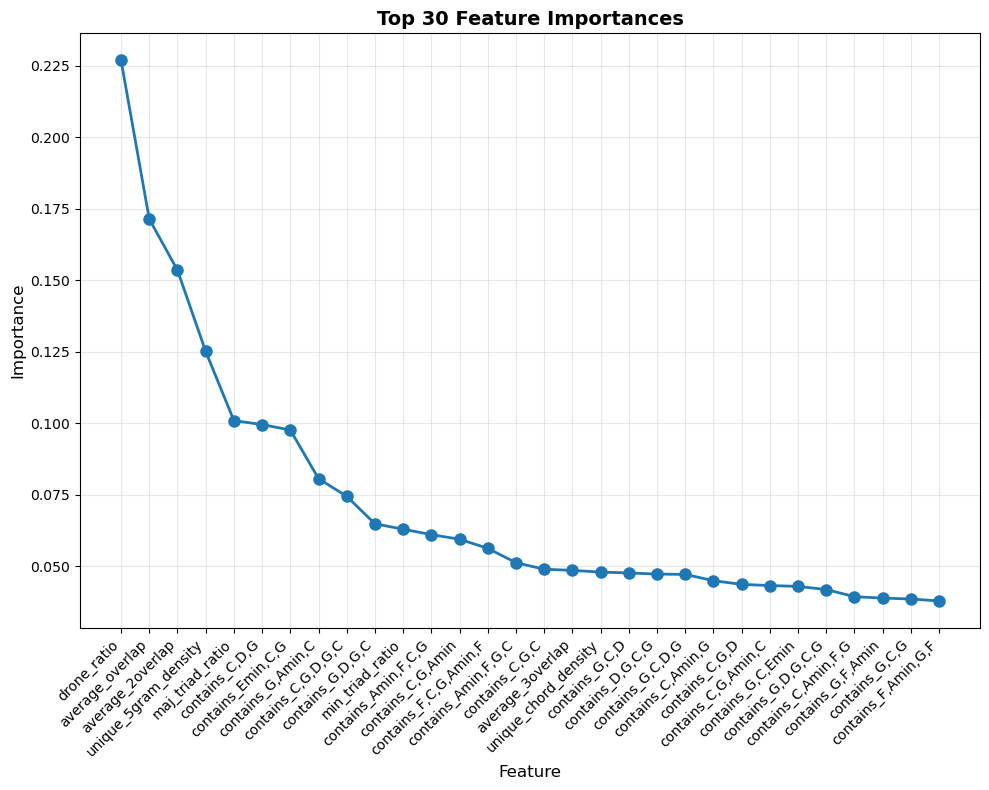

In [46]:
path_feature_selection = Path('feature_selection/')
print(os.listdir(path_feature_selection))

feature_selection = pd.read_csv(path_feature_selection / f'lasso_feature_importance_{target_variable}.csv')
print(feature_selection.columns)

# # Plot feature importance for all features
#ax = plot_feature_importance(feature_selection)

# Plot feature importance for top N features
ax = plot_feature_importance_df(feature_selection, top_n=30)

# Select top N features or comment out to use all features
predictor_columns = feature_selection.head(7)['feature'].astype(str).tolist()
print(predictor_columns)

In [47]:
# Filter data here

train_data_filtered = train_data[pd.to_numeric(train_data['decade'], errors='coerce') >= 1990].reset_index(drop=True)
test_data_filtered = test_data[pd.to_numeric(test_data['decade'], errors='coerce') >= 1990].reset_index(drop=True)

# Make a dataframe with predictor features
X_train = train_data_filtered[predictor_columns]
y_train = train_data_filtered[target_variable]

X_test = test_data_filtered[predictor_columns]
y_test = test_data_filtered[target_variable]

X_test

,drone_ratio,average_overlap,average_2overlap,unique_5gram_density,maj_triad_ratio,"contains_C,D,G","contains_Emin,C,G"
0,0.786325,1.086207,1.843478,0.205128,0.777778,0,0
1,0.871795,1.605263,2.189189,0.230769,0.435897,0,0
2,0.686747,0.731707,0.839506,0.108434,0.638554,0,0
3,0.787037,0.794393,1.773585,0.120370,0.796296,0,0
4,0.750000,1.225352,1.600000,0.250000,0.000000,0,0
...,...,...,...,...,...,...,...
27333,1.000000,2.581395,2.541176,0.218391,0.310345,0,0
27334,0.575758,0.593750,1.322581,0.575758,1.000000,0,0
27335,0.611765,0.880952,1.277108,0.858824,0.741176,0,0
27336,1.000000,1.575758,2.138462,0.134328,0.611940,0,0


In [48]:
#class imbalance for training data
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def evaluate_model(name, model, X_test, y_test, plot_cm=False):
    """Evaluate model and print standard metrics."""
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc:.4f}")

    if plot_cm:
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix – {name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC_AUC": roc
    }


📊 Dummy Classifier Results:
Accuracy:  0.5032
Precision: 0.0275
Recall:    0.5173
F1 Score:  0.0522
ROC AUC:   0.5000


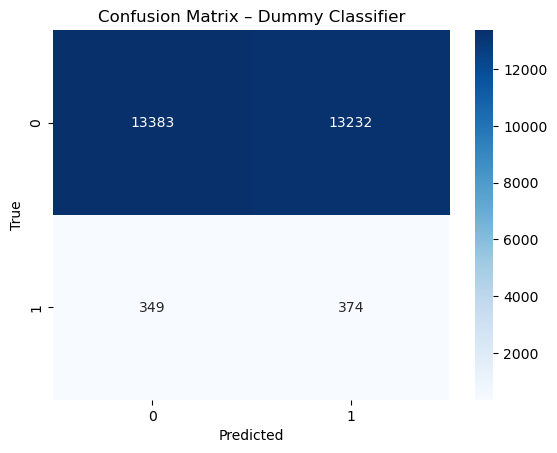


📊 Logistic Regression Results:
Accuracy:  0.5503
Precision: 0.0343
Recall:    0.5892
F1 Score:  0.0648
ROC AUC:   0.5956


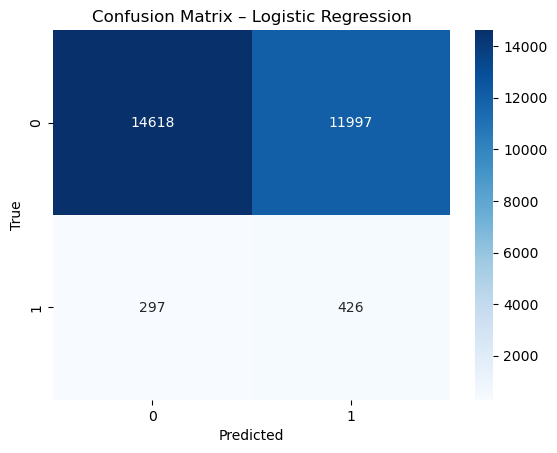


📊 Lasso (L1 Logistic) Results:
Accuracy:  0.5506
Precision: 0.0343
Recall:    0.5892
F1 Score:  0.0649
ROC AUC:   0.5956


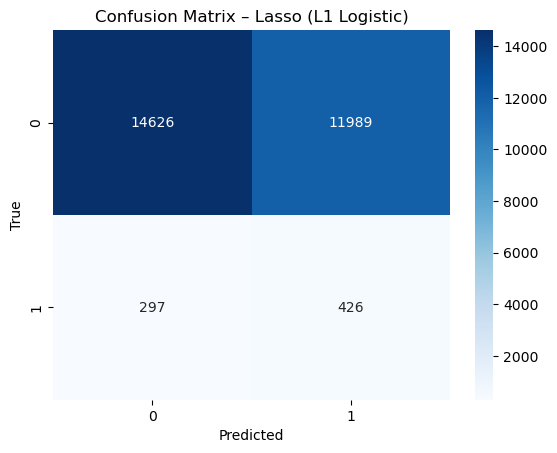


📊 Random Forest Results:
Accuracy:  0.8016
Precision: 0.0506
Recall:    0.3665
F1 Score:  0.0890
ROC AUC:   0.6296


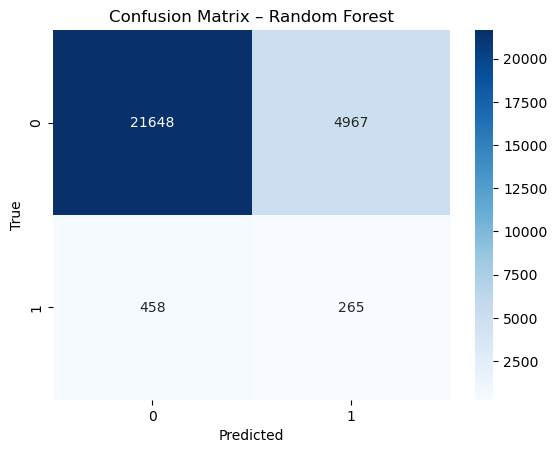

In [42]:
# Train and fit logistic regression model here (uses ridge regression for regression variables)

results = []

dummy = DummyClassifier(strategy='uniform')
dummy.fit(X_train, y_train)
results.append(evaluate_model("Dummy Classifier", dummy, X_test, y_test, plot_cm=True))

log_reg = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    C=1.0,
    max_iter=1000,
    random_state=42
)
log_reg.fit(X_train_scaled, y_train)
results.append(evaluate_model("Logistic Regression", log_reg, X_test_scaled, y_test, plot_cm=True))

lasso = LogisticRegression(
    penalty='l1',
    solver='saga',
    C=1.0,
    max_iter=5000,
    random_state=42
)
lasso.fit(X_train_scaled, y_train)
results.append(evaluate_model("Lasso (L1 Logistic)", lasso, X_test_scaled, y_test, plot_cm=True))

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
results.append(evaluate_model("Random Forest", rf, X_test, y_test, plot_cm=True))



✅ Final Comparison:
                 Model  Accuracy  Precision    Recall        F1   ROC_AUC
3        Random Forest  0.801558   0.050650  0.366528  0.089001  0.629640
2  Lasso (L1 Logistic)  0.550589   0.034313  0.589212  0.064850  0.595623
1  Logistic Regression  0.550296   0.034291  0.589212  0.064811  0.595583
0     Dummy Classifier  0.503219   0.027488  0.517289  0.052202  0.500000


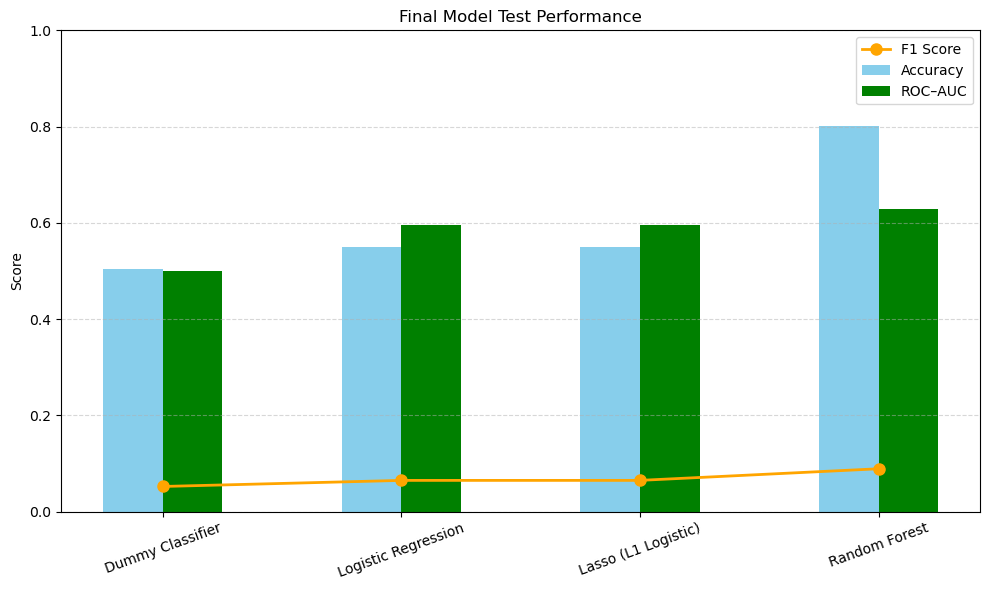

In [ ]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="ROC_AUC", ascending=False))

x = np.arange(len(results_df))
width = 0.25  # width of each bar

plt.figure(figsize=(10, 6))

# Bars for Accuracy and ROC–AUC
plt.bar(x - width/2, results_df["Accuracy"], width=width, label="Accuracy", color="skyblue")
plt.bar(x + width/2, results_df["ROC_AUC"], width=width, label="ROC–AUC", color="green")

# Line with markers for F1
plt.plot(x, results_df["F1"], 'o-', color="orange", label="F1 Score", linewidth=2, markersize=8)

# Formatting
plt.xticks(x, results_df["Model"], rotation=20)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Final Model Test Performance")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()